# Testing for multipolygons

Sometimes the functions are expecting polygons to work, and multipolygons make them break. Here is an imperfect workaround.

In [1]:
import geopandas as gpd
import sys
import os
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt

In [2]:
path_root = r'C:/Users/miln/tubCloud/Work-in-progress/building-project/git-ufo-map'

# enable python to find the modules
sys.path.append(path_root)

from ufo_map.Utils.helpers import import_csv_w_wkt_to_gdf,combined_multipoly_to_poly

In [3]:
path_data = os.path.join(path_root,'testing','Data_Testing','Berlin_200_buildings.csv')

In [4]:
crs = 'epsg:25833'

In [5]:
gdf = import_csv_w_wkt_to_gdf(path_data,crs)

Here we see that we have two polygons for this row.

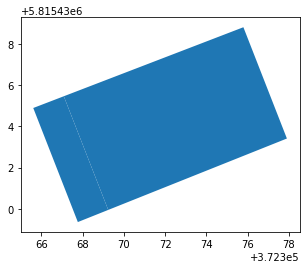

In [6]:
fig, ax = plt.subplots(figsize=(5,5))

gdf.loc[[156]].geometry.plot(ax=ax)

plt.show()

This is a multipolygon...

In [7]:
type(gdf.loc[156].geometry)

shapely.geometry.multipolygon.MultiPolygon

Let's say now we wanted to compute the following function Phi, which computes the ratio between the area of the smallest circle around the polygon and the area of the polygon. (This is a measure of how 'squared' the building is.) For that it needs to access the exterior attribute of the polygon to compute the smallest distance to the centroid...

In [8]:
poly = gdf.loc[156].geometry

In [9]:
def Phi(poly):
    max_dist = poly.centroid.hausdorff_distance(poly.exterior)
    circle_area = poly.centroid.buffer(max_dist).area
    return poly.area / circle_area

Meh! It does not work. We get an error that this multipolygon does not have an exterior. This makes sense, it has two exterior linearings so the Shapely devs decided not to have this attribute here.

In [10]:
Phi(poly)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

Now, this is going to be problem if we want to apply this function to our whole dataframe. Let's check if we have some other multipolygons.

In [11]:
[ind for ind, x in enumerate(gdf.geometry) if type(x) == MultiPolygon]

[8, 12, 26, 88, 156]

We have 5 of them. To run our function, we will remove them. There are two easy ways to do it: 1) adding a very small buffer around the several polygons will make them one if they are touching, 2) if they are not, we cannot do anything, so in cases when we have a single attribute for the whole building, we decide to take only the largest polygon. This is all implemented in the `combined_multipoly_to_poly` function.

In [12]:
gdf = combined_multipoly_to_poly(gdf,buffer_size=0.01)

Initial multipolygons: 5
Trying to remove multipolygons with a small buffer...
Remaining multipolygons: 0


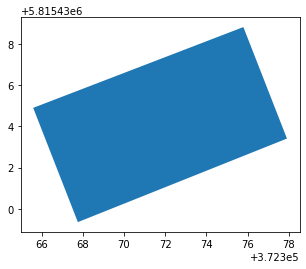

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

gdf.loc[[156]].geometry.plot(ax=ax)

plt.show()

In [14]:
poly = gdf.loc[156].geometry
Phi(poly)

0.5319227014583741

Tada! In this case, we had only touching polygons in our multipolygons, as indicated in the print. Now we have a normal polygon and we can compute the function. :)